# Pupil position and diameter
Is pupil position modulated by stimulus, choice, bias?

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import  get_dlc_XYs, get_raw_and_smooth_position, get_pupil_diameter, stack_pupil, pupil_center
from one_functions_generic import prepro

one = ONE()


### Get data

In [2]:
# Parameters 
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'  # Example session
# eid = '15f742e1-1043-45c9-9504-f1e8a53c1744'
video_type = 'left'
ephys=True

# Pupil data
x_raw_data, x_smooth_data, y_raw_data, y_smooth_data = get_raw_and_smooth_position(eid, video_type, ephys, pupil_center)
x_raw_diam, x_smooth_diam, _, _ = get_raw_and_smooth_position(eid, video_type, ephys, get_pupil_diameter)

times, XYs = get_dlc_XYs(eid, video_type)

# Trials data
trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()
processed_trials = prepro(trials_df)


/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
local md5 mismatch on dataset: cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.npy


Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.304738a6-9753-4607-8110-d9e3fa2adfde.npy Bytes: 2840


100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  2.86s/it]


### Stack data

In [5]:
# Plotting
event = 'stimOn_times'
event = 'feedback_times'
events = ['stimOn_times', 'firstMovement_onset', 'feedback_times']
t_init = 0.5
t_end = 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

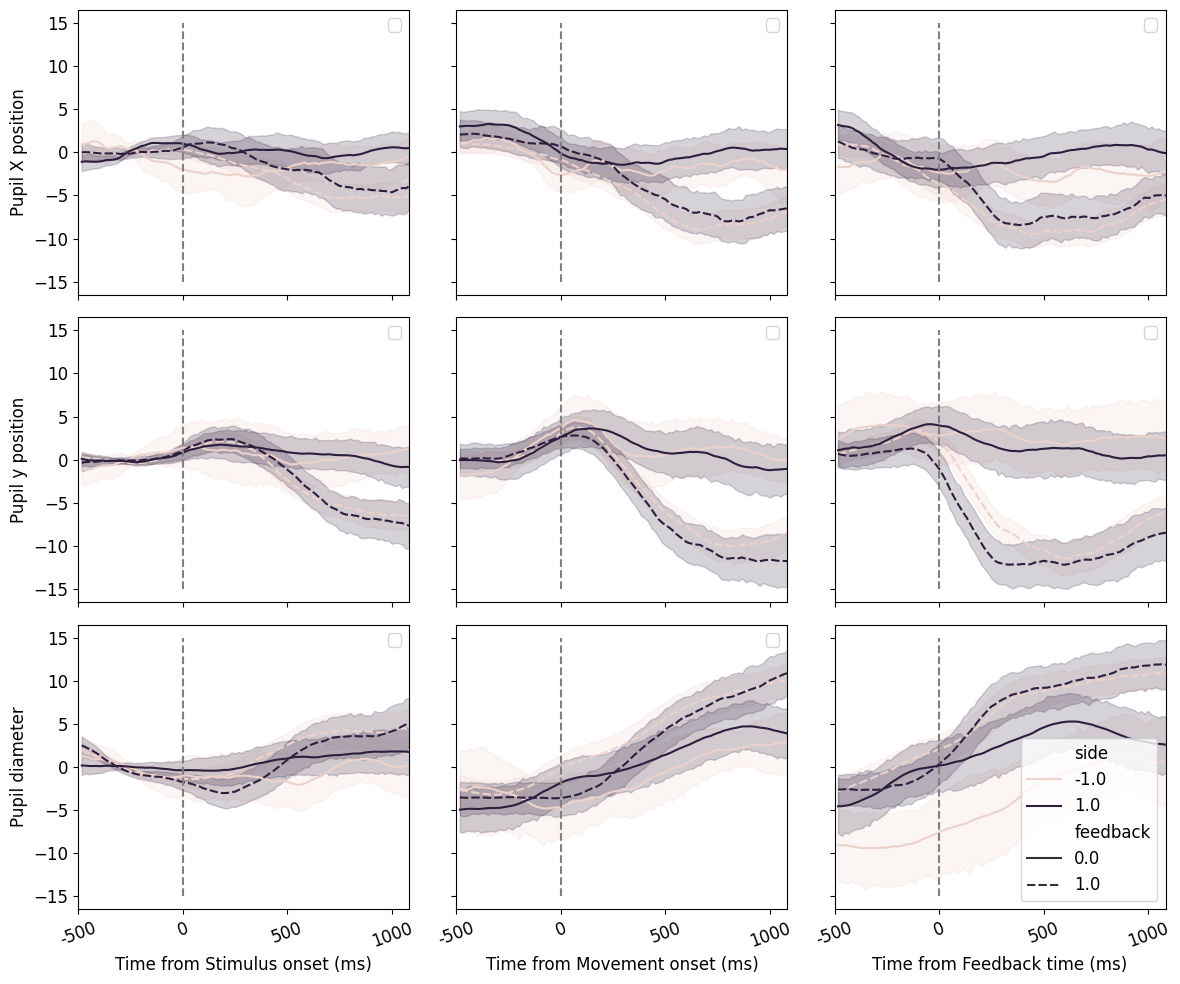

In [14]:

# Parameters 
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'  # Example session
# eid = '15f742e1-1043-45c9-9504-f1e8a53c1744'
video_type = 'left'
ephys=True

# Pupil data
x_raw_data, x_smooth_data, y_raw_data, y_smooth_data = get_raw_and_smooth_position(eid, video_type, ephys, pupil_center)
x_raw_diam, x_smooth_diam, _, _ = get_raw_and_smooth_position(eid, video_type, ephys, get_pupil_diameter)

times, XYs = get_dlc_XYs(eid, video_type)

# Trials data
trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()
processed_trials = prepro(trials_df)



to_plot = [x_smooth_data, y_smooth_data, x_smooth_diam]
label = ['Pupil X position', 'Pupil y position', 'Pupil diameter']
events = ['stimOn_times', 'firstMovement_times', 'feedback_times']
event_label = ['Stimulus onset', 'Movement onset', 'Feedback time']

fig, ax = plt.subplots(nrows=3 , ncols=3, sharex=True, sharey=True, figsize=[12, 10])

for p, pos in enumerate(to_plot):

       position = pos
       time = times[0:len(position)]
       trials = trials_df
       trials = processed_trials
       for ev, event in enumerate(events):
              stacked_pupil, stack_time = stack_pupil(position, time, trials, event, t_init, t_end)

              pupil_stack = pd.DataFrame(stacked_pupil[:,0:100])
              pupil_stack['feedback'] = list(processed_trials['correct'])
              pupil_stack['choice'] = list(processed_trials['choice'])
              pupil_stack['contrast'] = list(processed_trials['contrast'])
              pupil_stack['side'] = list(np.sign(processed_trials['signed_contrast']))

              melted = pd.melt(pupil_stack, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(pupil_stack.keys()[1:-4]))
              correct_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==1)]
              incorrect_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==0)]
              use_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1)]
              plt.rc('font', size=12)
              if ev == 2 & p == 2:
                     sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev])  #  style='feedback',
              else:
                     sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev], legend=None)  #  style='feedback',
              ax[p, ev].vlines(30, -15, 15, linestyles='dashed', color='Gray')
              ax[p, ev].set_xlabel(str('Time from '+ event_label[ev] +' (ms)'))
              ax[p, ev].set_ylabel(label[p])
              ax[p, ev].set_xticks([0, 30, 60, 90], [-500, 0, 500, 1000],
                     rotation=20)
              ax[p, ev].set_xlim([0, 95])
              ax[p, ev].legend()
              # plt.title(eid)

plt.tight_layout()
plt.show()


## Loop through sessions

In [18]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/'
# data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video and wheel/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_dlc_bwm_sessions_metadata", "rb"))


In [ ]:
# Parameters 
video_type = 'left'
ephys=True
label = ['Pupil X position', 'Pupil y position', 'Pupil diameter']
events = ['stimOn_times', 'firstMovement_times', 'feedback_times']
event_label = ['Stimulus onset', 'Movement onset', 'Feedback time']

/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an 

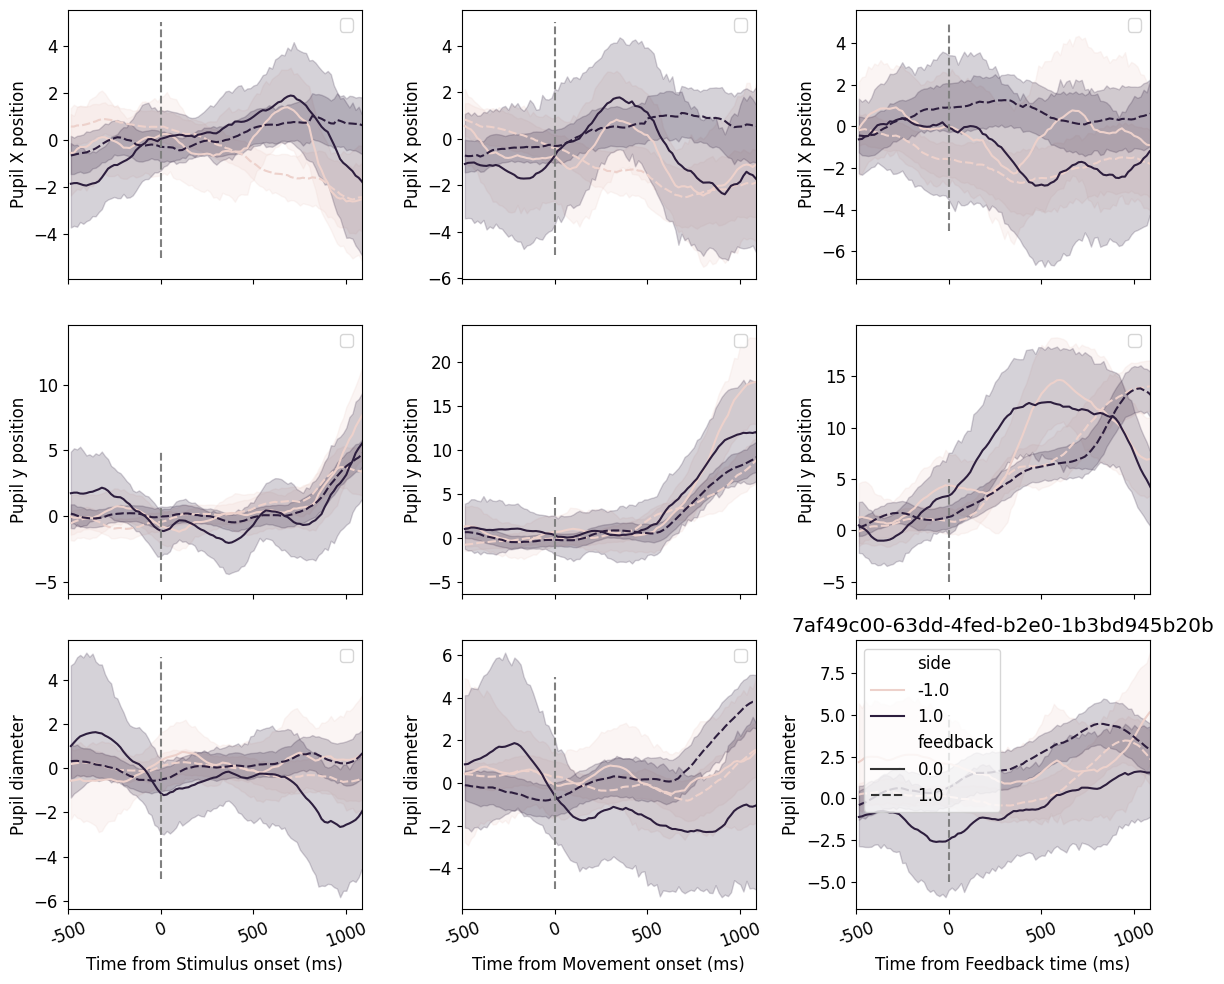

/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an 

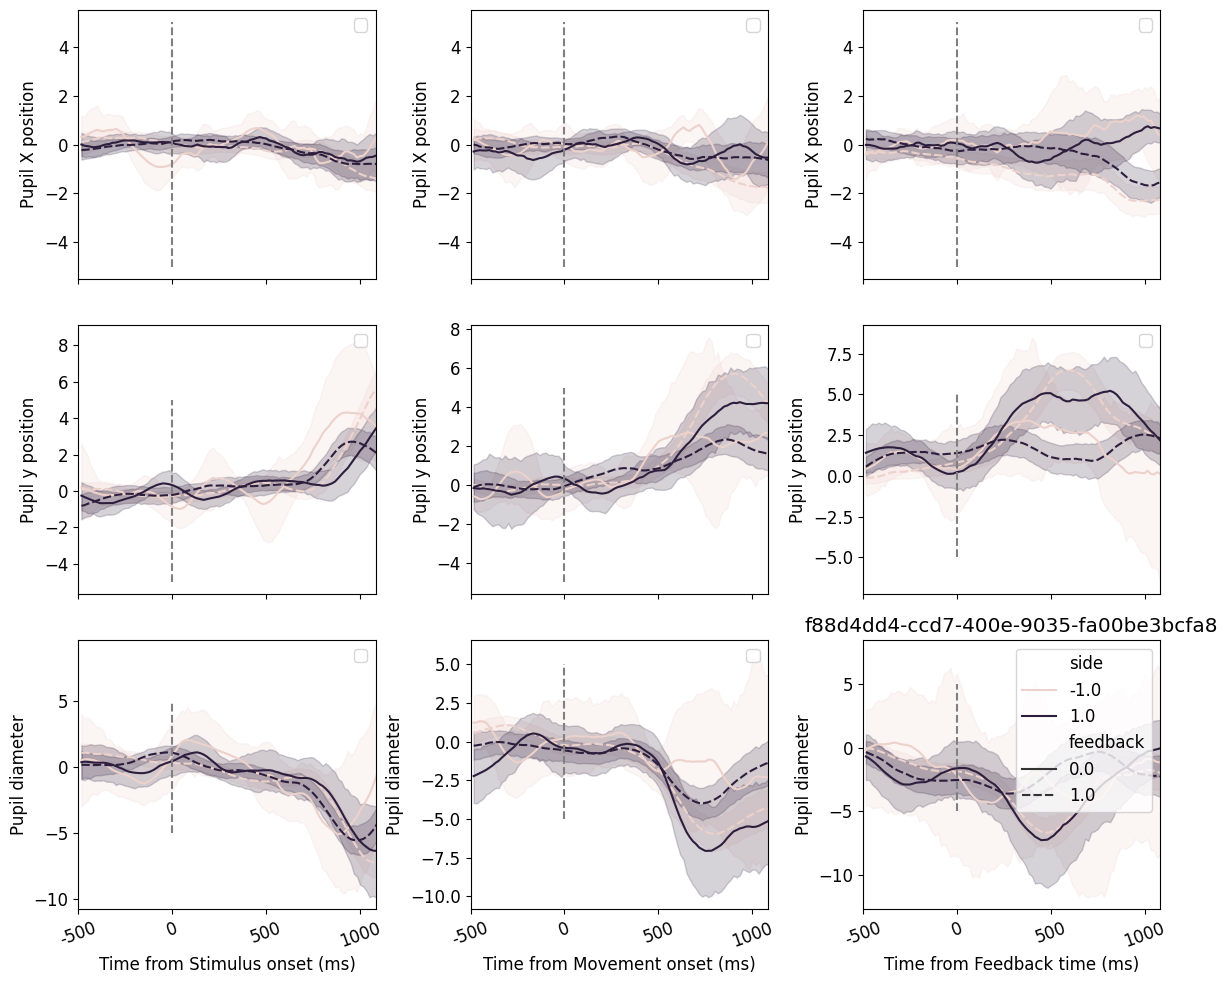

/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an 

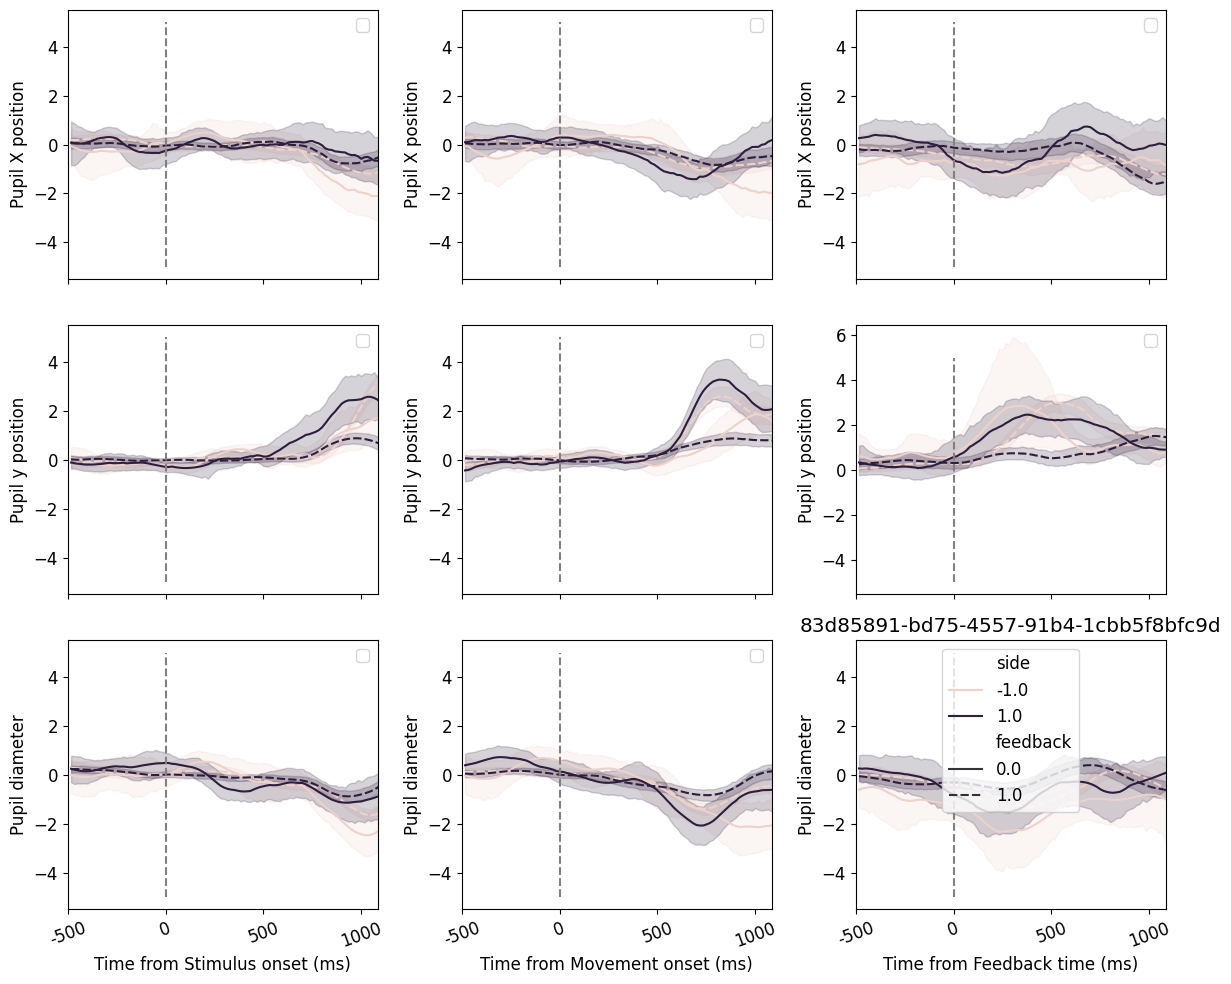

Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-37/2021-01-30/001/alf/_ibl_leftCamera.dlc.46d0f46d-f771-4a85-abd0-1d20c719eb63.pqt Bytes: 86460336


100%|██████████| 82.45500183105469/82.45500183105469 [00:42<00:00,  1.96it/s]
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:452: RuntimeWarning: Mean of empty slice
  X = np.nanmean(np.stack((l[:, 0], r[:, 0]), axis=0), axis=0)
/home/ines/repositories/representation_learning_variability/Functions/video_functions.py:453: RuntimeWarning: Mean of empty slice
  Y = np.nanmean(np.stack((t[:, 1], b[:, 1]), axis=0), axis=0)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-37/2021-01-30/001/alf/_ibl_trials.goCueTrigger_times.465066c5-20f5-444b-a321-8342f147de2f.npy Bytes: 5320Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-37/2021-01-30/001/alf/_ibl_trials.table.97949d07-5c3e-46b5-bad6-db3c78402b9c.pqt Bytes: 53203



100%|██████████| 0.00507354736328125/0.00507354736328125 [00:00<00:00,  1.27it/s]


Downloading: /home/ines/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-37/2021-01-30/001/alf/_ibl_trials.stimOff_times.ed7076cf-9094-489f-95ac-7a63f1cb65e9.npy Bytes: 5320


100%|██████████| 0.00507354736328125/0.00507354736328125 [00:00<00:00,  2.51it/s]
100%|██████████| 0.05073833465576172/0.05073833465576172 [00:00<00:00,  6.79s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Not

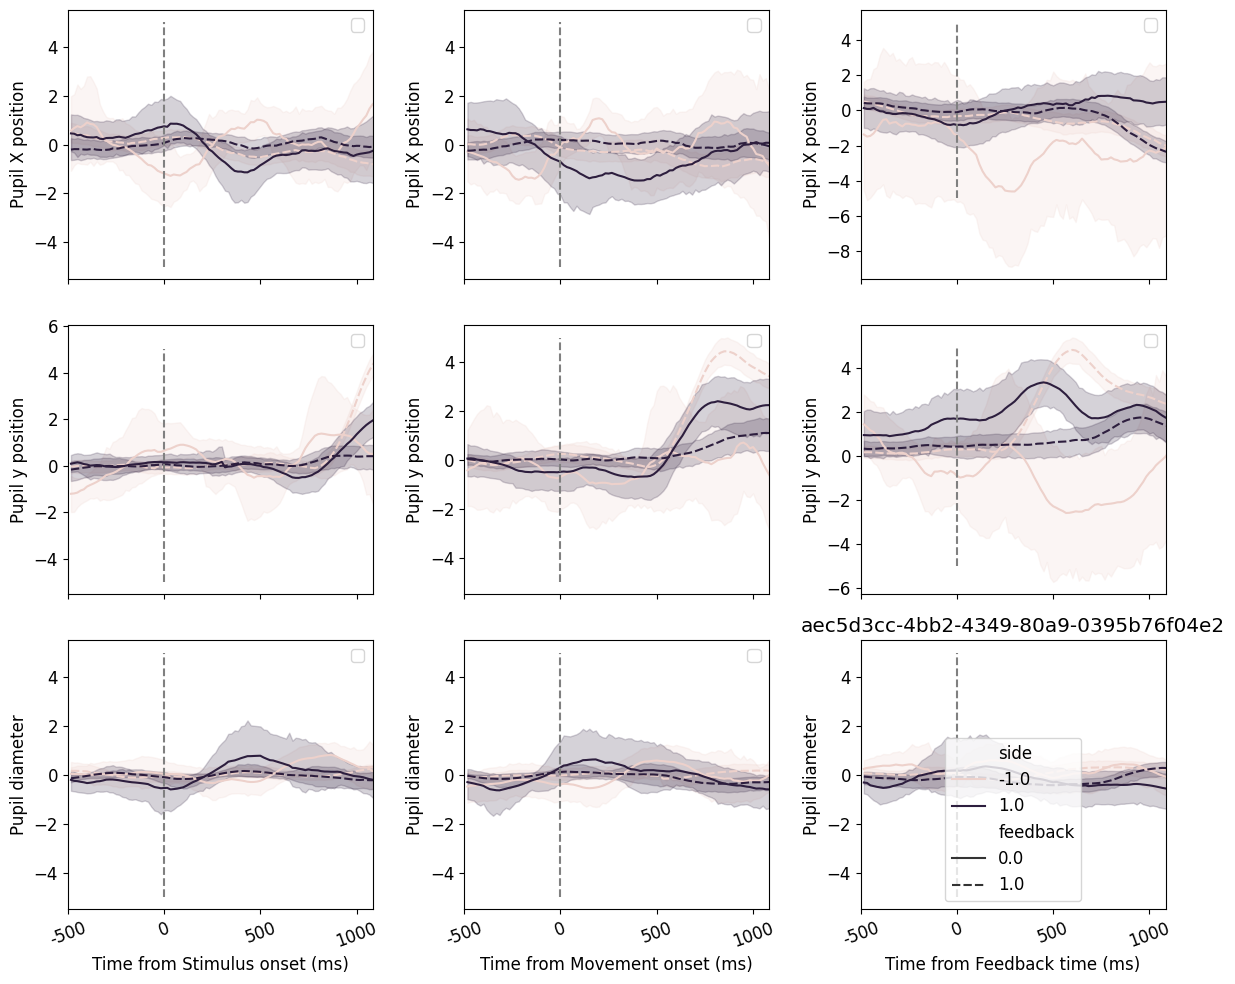

In [23]:
for e, eid in enumerate(pass_qc['session_uuid']):
    
    try:
        # Pupil data
        x_raw_data, x_smooth_data, y_raw_data, y_smooth_data = get_raw_and_smooth_position(eid, video_type, ephys, pupil_center)
        x_raw_diam, x_smooth_diam, _, _ = get_raw_and_smooth_position(eid, video_type, ephys, get_pupil_diameter)

        times, XYs = get_dlc_XYs(eid, video_type)

        # Trials data
        trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
        trials_df = trials_mouse.to_df()
        processed_trials = prepro(trials_df)

        to_plot = [x_smooth_data, y_smooth_data, x_smooth_diam]

        fig, ax = plt.subplots(nrows=3 , ncols=3, sharex=True, sharey=False, figsize=[12, 10])

        for p, pos in enumerate(to_plot):

                position = pos
                time = times[0:len(position)]
                trials = trials_df
                trials = processed_trials
                for ev, event in enumerate(events):
                        stacked_pupil, stack_time = stack_pupil(position, time, trials, event, t_init, t_end)

                        pupil_stack = pd.DataFrame(stacked_pupil[:,0:100])
                        pupil_stack['feedback'] = list(processed_trials['correct'])
                        pupil_stack['choice'] = list(processed_trials['choice'])
                        pupil_stack['contrast'] = list(processed_trials['contrast'])
                        pupil_stack['side'] = list(np.sign(processed_trials['signed_contrast']))

                        melted = pd.melt(pupil_stack, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(pupil_stack.keys()[1:-4]))
                        correct_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==1)]
                        incorrect_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1) & (melted['feedback']==0)]
                        use_data = melted.loc[(melted['contrast']>0) & (melted['contrast']<=1)]
                        plt.rc('font', size=12)
                        if ev == 2 & p == 2:
                                sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev])  #  style='feedback',
                        else:
                                sns.lineplot(x='variable', y='value', hue='side',style='feedback', data=use_data, ax=ax[p, ev], legend=None)  #  style='feedback',
                        ax[p, ev].vlines(30, -5, 5, linestyles='dashed', color='Gray')
                        ax[p, ev].set_xlabel(str('Time from '+ event_label[ev] +' (ms)'))
                        ax[p, ev].set_ylabel(label[p])
                        ax[p, ev].set_xticks([0, 30, 60, 90], [-500, 0, 500, 1000],
                                rotation=20)
                        ax[p, ev].set_xlim([0, 95])
                        ax[p, ev].legend()
                        plt.title(eid)

        plt.tight_layout()
        #     plt.show()
        fig_name = str('pupil_PSTH_'+eid+'png')
        plt.savefig(fig_name)

    except:
        print(str('Something wrong with ' + eid))
    

(0.0, 500.0)

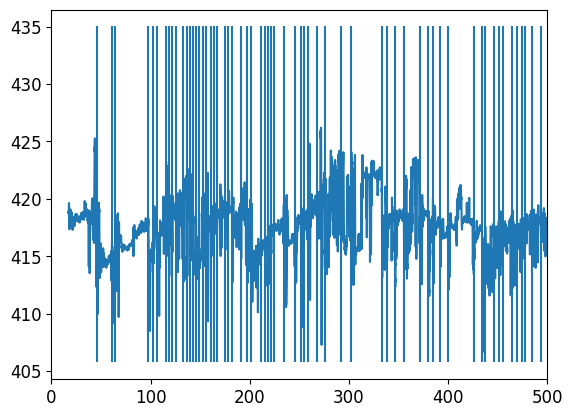

In [69]:
plt.plot(times[0:len(pupil_dia_smooth_left)], pupil_dia_smooth_left)
onset_times = list(trials[event])
for t, trial in enumerate(onset_times):
    plt.vlines(trial, np.nanmin(pupil_dia_smooth_left), np.nanmax(pupil_dia_smooth_left))
plt.xlim([0, 500])